# `DebyeCalculator` DEMO

[![DOI](https://joss.theoj.org/papers/10.21105/joss.06024/status.svg)](https://doi.org/10.21105/joss.06024) <br>

**Authors:** Johansen & Anker et. al.

**Questions:** [frjo@di.ku.dk](frjo@di.ku.dk) and [andy@chem.ku.dk](andy@chem.ku.dk)

**Date:** August 2024

<img src="logo.png" alt="drawing" width="250"/>

### Made for **EPDIC18:** Padua, Italy, 2024 ☀️

---
`DebyeCalculator` is a powerful tool for calculating the scattering intensity $I(Q)$ through the Debye scattering equation, the Total Scattering Structure Function $S(Q)$, the Reduced Total Scattering Function $F(Q)$, and the Reduced Atomic Pair Distribution Function $G(r)$.
This class is optimized to run on GPUs, making it well-suited for large-scale simulations and nanoparticle analysis. It utilizes PyTorch to efficiently perform tensor computations and takes advantage of CUDA acceleration for enhanced speed.

In this notebook, we will demonstrate how to use the `DebyeCalculator` class to calculate scattering for discrete nanoparticles, as well as show some of its many capabilities.

---
Let's get started with an overview of the `DebyeCalculator` class and its main functionalities.

In its simplicity, all you really need to do to start using `DebyeCalculator` is to import the following class:

In [231]:
# The calculator class
from debyecalculator import DebyeCalculator

For the sake of the examples below, we will import some helper functions for generating a variety of particles as well as some function for timing and visualizing the particles and the scattering signals. 

In [232]:
# Some helper functions for generating particles
from debyecalculator.utility.generate import (
    generate_core_shell_models, 
    generate_core_shell_models_fixed_size, 
    generate_substitutional_alloy_models,
    generate_periodic_plane_substitution,
    generate_spherical_particle,
)

# Some classes for timing and visualising
import time
import torch
import numpy as np
from tqdm.auto import tqdm, trange
from ase.visualize.plot import plot_atoms
from ase.data.colors import jmol_colors
from ase.data import chemical_symbols
import matplotlib.pyplot as plt
from matplotlib import colormaps as cmaps
from matplotlib.patches import Patch
plt.rcParams.update({'font.size': 7})

---
## Creating an Instance of DebyeCalculator

To use the `DebyeCalculator` class, you need to create an instance of it. The constructor of the class allows you to set various parameters for the Debye scattering calculations. Here's how you can create an instance:

```python
from debye_calculator import DebyeCalculator

# Create an instance 'calc' of DebyeCalculator
calc = DebyeCalculator(
    qmin = 0.0,        # Minimum Q (1/Å).
    qmax = 30.0,       # Maximum Q (1/Å).
    qstep = 0.1,       # Step size for Q (1/Å) (Nyquist-sampled at default)
    qdamp = 0.0,       # Debye-Waller damping factor.

    rmin = 0.0,        # Minimum R (Å).
    rmax = 20.0,       # Maximum R (Å).
    rstep = 0.01,      # Step size for R (Å).
    rthres = 0.0,      # Lower threshold (Å) radial distance for G(r) calculations.
    
    biso = 0.0,        # Debye-Weller isotropic atomic displacement factor.
    device='cuda',     # Device selection for GPU-accelerated computations. Use 'cuda' for GPU or 'cpu' for CPU.
    batch_size=None,   # Batched pairwise distance calculations (if not specified, it will be automatically determined).
    lorch_mod=False,   # Lorch modification factor for G(r) calculations.
    rad_type='xray',   # Radiation type for scattering calculations. Use 'xray'/'x' or 'neutron'/'n'
    profile=False,     # Activate profiler.
)

```

In [132]:
# Create a standard instance of DebyeCalculator and print it out to see its current parameters
calc = DebyeCalculator()
print(calc)

DebyeCalculator instance:
Q-min:        1.00
Q-max:       30.00
Q-step:       0.16
Q-damp:       0.04

r-min:        0.00
r-max:       20.00
r-step:       0.01
r-thres:      0.00

B-iso:        0.30

rad_type:    xray
lorch_mod:   False

batch_size:  10000
device:      cuda
profile:     False



---
## Generating total scattering from `.xyz`-files

Let's explore how to use the `iq` method from the `DebyeCalculator` class to calculate the scattering intensity $I(Q)$ for a particle defined from a `.xyz`-file.

This method takes the `.xyz` file and returns the scattering intensity $I(Q)$ at the specified $Q$ values as so:

```python
# Create an instance of DebyeCalculator with appropriate parameters
calc = DebyeCalculator(qmin=1.0, qmax=30.0, qdamp=0.0)

# Load a single particle from a .xyz file (replace "path/to/nanoparticle.xyz" with your file path)
q, iq = calc.iq("path/to/nanoparticle.xyz")

```
**Note:** The example above demonstrates how to calculate $I(Q)$ for a single nanoparticle using an `.xyz` file. You can alternatively parse an `.cif` file as demonstrated in the next section 

##### Let's do it in practice and plot it!

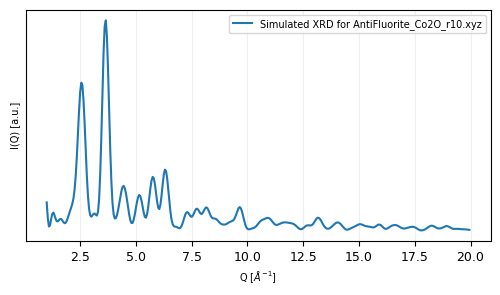

In [181]:
# Generate
calc = DebyeCalculator(qmin=1.0, qmax=20.0, qstep=0.05, qdamp=0.0, biso=0.0)
path_to_xyz_file = "data/AntiFluorite_Co2O_r10.xyz"
q, iq = calc.iq(path_to_xyz_file)

# Plot
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(q, iq, label=f"Simulated XRD for {path_to_xyz_file.split('/')[-1]}")
ax.set(xlabel='Q [$Å^{-1}$]', ylabel='I(Q) [a.u.]', yticks=[])
ax.grid(alpha=0.2)
ax.legend()
plt.show()

##### Let's try to compare the pattern generated from x-rays and neutrons:
The parameters can be changed on the fly using the build-in ``update_parameters`` method

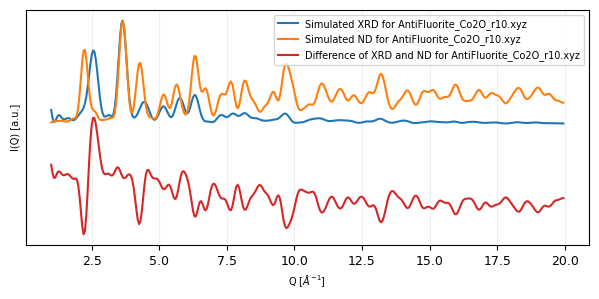

In [180]:
# Make instance (again for the sake of example)
calc = DebyeCalculator(qmin=1.0, qmax=20.0, qstep=0.05, qdamp=0.0, biso=0.15)
path_to_xyz_file = "data/AntiFluorite_Co2O_r10.xyz"

# Generate XRD
q, iq_xray = calc.iq(path_to_xyz_file)
iq_xray /= max(iq_xray)

# Update and generate ND
calc.update_parameters(rad_type='neutron')
q, iq_neu = calc.iq(path_to_xyz_file)
iq_neu /= max(iq_neu)

# Since the q-range is the same we can compare
fig, ax = plt.subplots(figsize=(6,3))
    
ax.plot(q, iq_xray, label=f"Simulated XRD for {path_to_xyz_file.split('/')[-1]}", c='#1f77b4')
ax.plot(q, iq_neu, label=f"Simulated ND for {path_to_xyz_file.split('/')[-1]}", c='#ff7f0e')
ax.plot(q, iq_xray-iq_neu - .5, label=f"Difference of XRD and ND for {path_to_xyz_file.split('/')[-1]}", c='#d62728')


ax.set(xlabel='Q [$Å^{-1}$]', ylabel='I(Q) [a.u.]', yticks=[])
ax.grid(alpha=0.2)
ax.legend()

fig.tight_layout()
plt.show()

---
## Generating total scattering from `.cif`-files

The `iq` method can also be used to generate a spherical particle from a `.cif`-file based on specific radii and subsequently generate scattering intensities for every particle in the set, at the specified Q values:

```python
# Create an instance of DebyeCalculator with appropriate parameters
calc = DebyeCalculator(qmin=1.0, qmax=30.0, qdamp=0.0)

# Load a .cif-file and generate I(Q) from different sizes spherical particles
# (replace "path/to/crystalfile.cif" with your file path)
(q, iq_5), (q, iq_10) = calculator.iq(structure_path = "path/to/crystalfile.cif", radii = [5.0, 10.0])

```

##### Let's do it in practice and plot it!

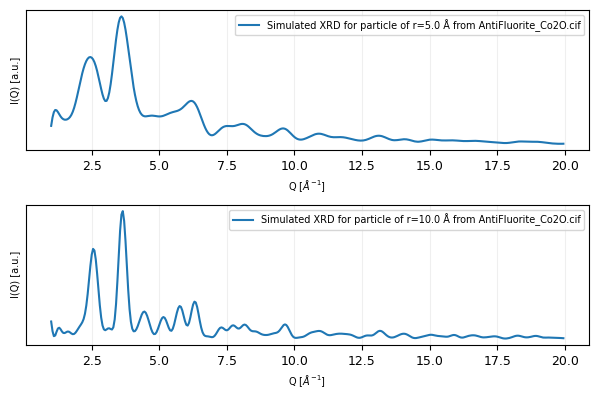

In [179]:
# Generate
calc = DebyeCalculator(qmin=1.0, qmax=20.0, qstep=0.05, qdamp=0.0, biso=0.0)
path_to_xyz_file = "data/AntiFluorite_Co2O.cif"
radii = [5.0, 10.0] # Å
(q, iq_5), (q, iq_10) = calc.iq(path_to_xyz_file, radii)

# Plot
fig, axes = plt.subplots(2,1,figsize=(6,4))
ax_5, ax_10 = axes

ax_5.plot(q, iq_5, label=f"Simulated XRD for particle of r={radii[0]} Å from {path_to_xyz_file.split('/')[-1]}")
ax_10.plot(q, iq_10, label=f"Simulated XRD for particle of r={radii[1]} Å from {path_to_xyz_file.split('/')[-1]}")

for ax in axes:
    ax.set(xlabel='Q [$Å^{-1}$]', ylabel='I(Q) [a.u.]', yticks=[])
    ax.grid(alpha=0.2)
    ax.legend()

fig.tight_layout()
plt.show()

##### Let's see the size dependence on the PDF in action

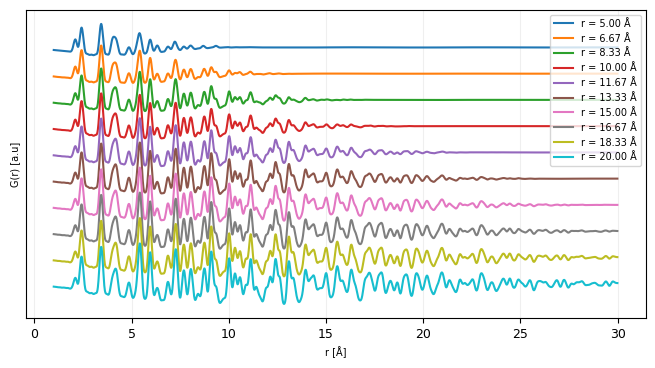

In [185]:
# Generate
calc = DebyeCalculator(rmin=1.0, rmax=30.0)
path_to_xyz_file = "data/AntiFluorite_Co2O.cif"

N = 10
gr_radii = np.linspace(5.0, 20.0, N) # Å
gr_output = calc.gr(path_to_xyz_file, list(gr_radii))

# Plotting
fig, ax = plt.subplots(figsize=(8, 4))

for i, (x, y) in enumerate(gr_output):
    ax.plot(x, y - i*5, label=f'r = {gr_radii[i]:.2f} Å')

ax.set(xlabel = 'r [Å]', ylabel = 'G(r) [a.u]', yticks=[])
ax.grid(alpha=0.2)
ax.legend(loc='upper right')
plt.show()

## Generating partial-scattering

`DebyeCalculator` allows user to extract the partial scattering of specific pairs of atomic species within structures. This is demonstrated below  

# Particle Playground

In the folllowing sections, we will explore how the `DebyeCalculator` can be used to model and analyze the scattering properties of simulated nanoparticles. We have prepared a few examples of how one could simulate particles with core-shell behaviour, substitutional alloy type particles and and toy-model intermetallic type alloys. We encourage to create your own models to test out the capabilities of `DebyeCalculator`.

## Fixed-sized core-shell particles.

Let's first generate some spherical core-shell particles with a fixed size and varying core-to-shell ratios.

In [137]:
# Set your parameters
core_element = 'Pd'
shell_element = 'Cu'
lattice_constant = 3.89
size = (10, 10, 10)
core_shell_ratios = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
radius = 15.0

# Generate core-shell models with fixed sizes and varying core-shell ratios
fixed_core_shell_models = generate_core_shell_models_fixed_size(
    core_element, 
    shell_element, 
    lattice_constant, 
    size, 
    core_shell_ratios, 
    radius,
)

We can run the following cell to visualize the particles. <br> <b>Notice</b> how we are cutting the particles in half when visualizing such that we can see the core getting larger.

Visualizing core-shell models...:   0%|          | 0/6 [00:00<?, ?it/s]

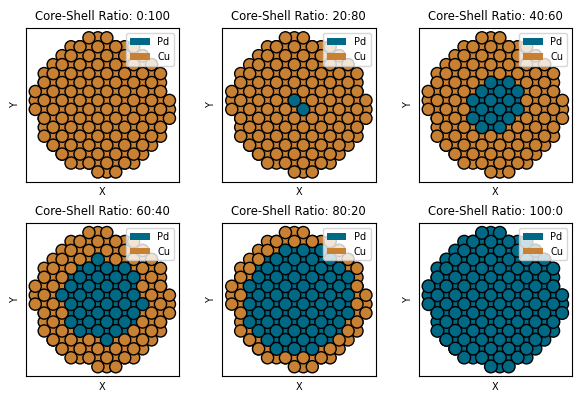

In [138]:
# Convert core-shell ratios into strings for labeling (e.g., "20:80")
core_shell_ratios_str = [f"{int(np.ceil(r*100))}:{int(np.floor(100 - r*100))}" for r in core_shell_ratios]

# Precompute colors and legend elements
core_color = jmol_colors[chemical_symbols.index(core_element)]
shell_color = jmol_colors[chemical_symbols.index(shell_element)]
legend_elements = [
    Patch(facecolor=core_color, label=core_element),
    Patch(facecolor=shell_color, label=shell_element),
]

# Visualization setup
fig, axes = plt.subplots(2, 3, figsize=(6, 4))
axes = axes.ravel()

# Loop through each core-shell model for visualization
for i in tqdm(range(len(core_shell_ratios)), total=len(core_shell_ratios), desc='Visualizing core-shell models...'):
    
    # Cut the particle in half for visualization and plot it
    structure = fixed_core_shell_models[i][fixed_core_shell_models[i].get_positions()[:, 2] <= 0]
    plot_atoms(structure, axes[i], show_unit_cell=0)

    # Set plot labels and title and legend
    axes[i].set(xlabel='X', ylabel='Y', title=f'Core-Shell Ratio: {core_shell_ratios_str[i]}', xticks=[], yticks=[], )
    axes[i].legend(handles=legend_elements, loc='upper right')

# Adjust layout to prevent overlap
fig.tight_layout()
plt.show()

Using the `DebyeCalculator` we can simulate the PDFs of all the particles at once and visualize how the PDF changes. <br> <b> Notice </b> how we are able to pass the entire list of ASE particle models to the `gr` method at once.

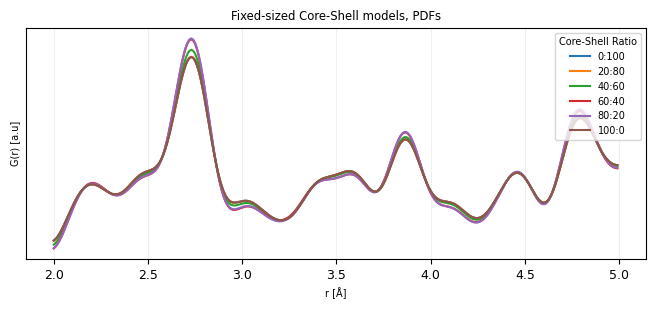

In [144]:
# Calculate Pair Distribution Functions (PDFs) for all models at once
calc = DebyeCalculator(rmin=2.0, rmax=5.0)
gr_output = calc.gr(fixed_core_shell_models)

# Plotting the PDFs
fig, ax = plt.subplots(figsize=(8, 3))

# Plot each G(r) curve with a unique color from the colormap
for i, (x, y) in enumerate(gr_output):
    ax.plot(x, y, label=f'{core_shell_ratios_str[i]}')

# Set plot labels and grid
ax.set(title = 'Fixed-sized Core-Shell models, PDFs', xlabel='r [Å]', ylabel='G(r) [a.u]', yticks=[])
ax.grid(alpha=0.2)

# Add a legend to differentiate the curves
ax.legend(title='Core-Shell Ratio', loc='upper right')

# Show the plot
plt.show()

## Growing-shell core-shell particles.

Here is an example with spherical core-shell particles with varying sized shells.

In [145]:
# Set your parameters
core_element = 'Pd'
shell_element = 'Au'
lattice_constant = 3.89
size = (10, 10, 10)
core_radius = 7.0
shell_thicknesses = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
radius = 15.0

# Generate core-shell models
growing_shell_models = generate_core_shell_models(
    core_element,
    shell_element, 
    lattice_constant,
    size, 
    core_radius,
    shell_thicknesses,
    radius,
)

We can run the following cell to visualize the particles. <br> <b>Notice</b> how we are cutting the particles in half when visualizing such that we can see the shell getting larger.

Visualizing core-shell models...:   0%|          | 0/6 [00:00<?, ?it/s]

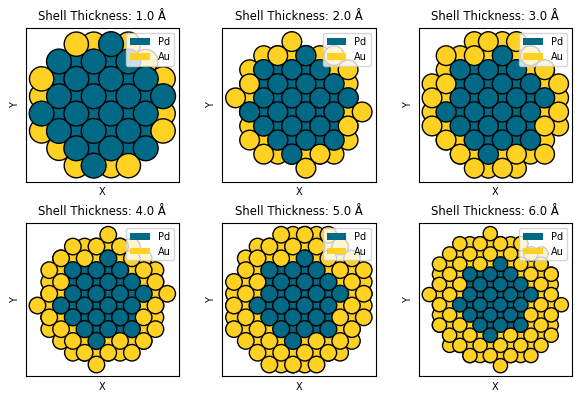

In [147]:
# Precompute colors and legend elements
core_color = jmol_colors[chemical_symbols.index(core_element)]
shell_color = jmol_colors[chemical_symbols.index(shell_element)]
legend_elements = [
    Patch(facecolor=core_color, label=core_element),
    Patch(facecolor=shell_color, label=shell_element),
]

# Visualize the core-shell models
fig, axes = plt.subplots(2, 3, figsize=(6, 4))
axes = axes.ravel()

for i, thickness in enumerate(tqdm(shell_thicknesses, desc='Visualizing core-shell models...')):
    structure = growing_shell_models[i][growing_shell_models[i].get_positions()[:, 2] <= 0]
    plot_atoms(structure, axes[i], show_unit_cell=0)
    
    axes[i].set(xlabel='X', ylabel='Y', title=f'Shell Thickness: {thickness} Å', xticks = [], yticks = [])
    axes[i].legend(handles=legend_elements, loc='upper right')

fig.tight_layout()
plt.show()

Using the `DebyeCalculator` we can simulate the PDFs of all the particles at once and visualize how the PDF changes. <br> <b> Notice </b> how we are able to pass the entire list of ASE particle models to the `gr` method at once.

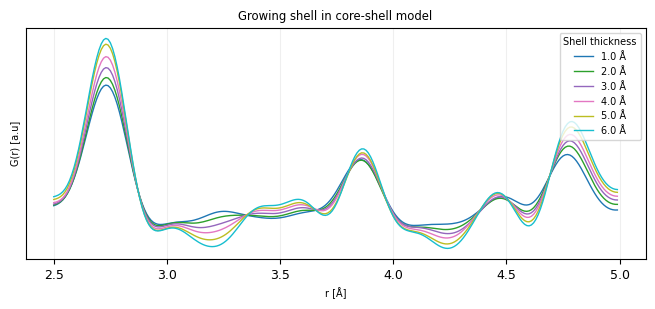

In [149]:
# Calculate PDFs
calc = DebyeCalculator(rmin=2.5, rmax=5.0)
gr_output = calc.gr(growing_shell_models)

index_of_interest = np.argmin(np.abs(gr_output[0][0] - r_value_of_interest))
gr_at_r_value = np.array([y[index_of_interest] for _, y in gr_output])

# Plot G(r) with an arrow at the specific r-value
fig, ax = plt.subplots(figsize=(8, 3))
colors = plt.cm.tab10(np.linspace(0, 1, len(shell_thicknesses)))

# Plot G(r) curves
for i, (x, y) in enumerate(gr_output):
    ax.plot(x, y, label=f'{shell_thicknesses[i]} Å', color=colors[i], lw=1)

ax.set(xlabel='r [Å]', ylabel='G(r) [a.u]', yticks=[], title=f'Growing shell in core-shell model')
ax.grid(alpha=0.2)
ax.legend(title='Shell thickness', loc='upper right')
plt.show()

### Substitutional alloy particles

Here is a simple example with substitutional bi-metallic alloys with varying ratios of the constituent metals.

In [189]:
# Parameters
base_element = 'Pd'
substitute_element = 'Ni'
lattice_constant = 3.89
size = (10, 10, 10)
substitution_ratios = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
radius = 15.0

# Generate substitutional alloy models with varying substitution ratios
sub_alloy_models = generate_substitutional_alloy_models(
    base_element,
    substitute_element, 
    lattice_constant,
    size,
    substitution_ratios,
    radius,
)

We can run the following cell to visualize the particles. <br> <b>Notice</b> how we are cutting the particles in half when visualizing.

Visualizing sub-alloy models...:   0%|          | 0/6 [00:00<?, ?it/s]

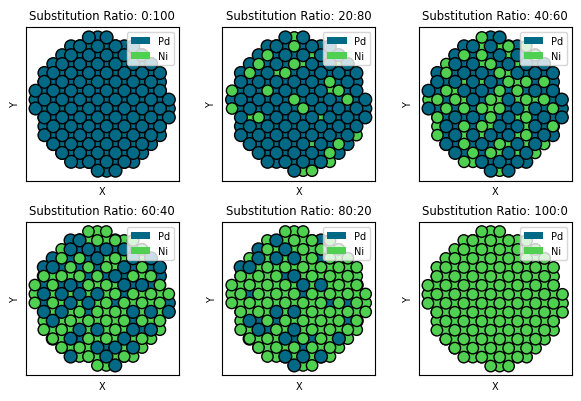

In [192]:
# Precompute colors and legend elements
base_color = jmol_colors[chemical_symbols.index(base_element)]
substitute_color = jmol_colors[chemical_symbols.index(substitute_element)]
legend_elements = [
    Patch(facecolor=base_color, label=base_element),
    Patch(facecolor=substitute_color, label=substitute_element),
]

# Convert substitution ratios into strings for labeling (e.g., "20:80")
substitution_ratios_str = [f"{int(np.ceil(r*100))}:{int(np.floor(100 - r*100))}" for r in substitution_ratios]

# Visualization setup
fig, axes = plt.subplots(2, 3, figsize=(6, 4))
axes = axes.ravel()

# Loop through each substitutional alloy model for visualization
for i in tqdm(range(len(substitution_ratios)), total=len(substitution_ratios), desc='Visualizing sub-alloy models...'):
    #Cut the particle in half for visualization and plot it
    structure = sub_alloy_models[i][sub_alloy_models[i].get_positions()[:, 2] <= 0]
    plot_atoms(structure, axes[i], show_unit_cell=0)
    
    # Set plot labels and legends
    axes[i].set(xlabel='X', ylabel='Y', title=f'Substitution Ratio: {substitution_ratios_str[i]}', xticks=[], yticks=[])
    axes[i].legend(handles=legend_elements, loc='upper right')

# Adjust layout to prevent overlap
fig.tight_layout()
plt.show()

Using the `DebyeCalculator` we can simulate the I(Q) of all the particles at once and visualize how the signal intensity changes. <br> <b> Notice </b> how we are able to pass the entire list of ASE particle models to the `iq` method at once.

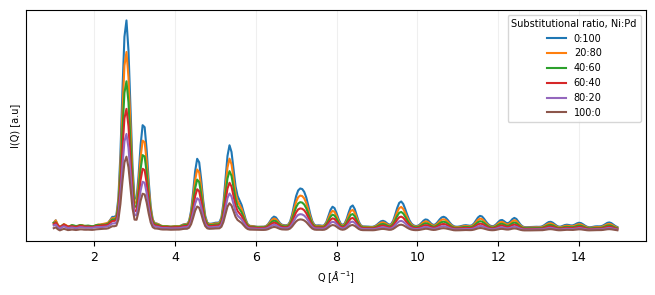

In [193]:
# Calculate scattering intensities for all models at once
calc = DebyeCalculator(qmin=1, qmax=15, qstep=0.05)
iq_output = calc.iq(sub_alloy_models)

# Plotting the scattering intensities
fig, ax = plt.subplots(figsize=(8, 3))

# Plot each G(r) curve with a unique color from the colormap
for i, (x, y) in enumerate(iq_output):
    ax.plot(x, y, label=f'{substitution_ratios_str[i]}')

# Set plot labels and grid
ax.set(xlabel='Q [$Å^{-1}$]', ylabel='I(Q) [a.u]', yticks=[])
ax.grid(alpha=0.2)

# Add a legend to differentiate the curves
ax.legend(loc='upper right', title=f'Substitutional ratio, {substitute_element}:{base_element}')

# Show the plot
plt.show()

## Intermetallic particles

Here is an example that compares an intermetallic particle (with periodic substitutional planes), a random mixture particle and a generic monometallic particle.

In [221]:
# Parameters
base_element = 'Pd'
substitute_element = 'Ni'
lattice_constant = 3.89
size = (15, 15, 15)
radius = 25.0
plane_spacing = 2  # Spacing between substitution planes
plane_orientation = 'x'  # Orientation of the planes ('x', 'y', or 'z')

# Generate periodic plane substitution model
periodic_plane_model = generate_periodic_plane_substitution(
    base_element, 
    substitute_element, 
    lattice_constant, 
    size, 
    radius,
    plane_spacing, 
    plane_orientation
)

# Generate substitional spherical particle model
sub_model = generate_substitutional_alloy_models(
    base_element=base_element,
    substitute_element = substitute_element, 
    substitution_ratios = [0.5],
    lattice_constant=lattice_constant,
    size=size,
    radius=radius,
)[0]

# Generate generic spherical particle model
generic_model = generate_spherical_particle(
    element=base_element,
    lattice_constant=lattice_constant,
    size=size,
    radius=radius,
)

We can run the following cell to visualize the particles. <br> <b>Notice</b> how we rotating the particle such that we can see the periodicity.

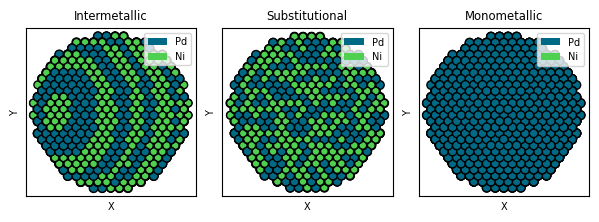

In [223]:
# Precompute colors and legend elements
base_color = jmol_colors[chemical_symbols.index(base_element)]
substitute_color = jmol_colors[chemical_symbols.index(substitute_element)]
legend_elements = [
    Patch(facecolor=base_color, label=base_element),
    Patch(facecolor=substitute_color, label=substitute_element),
]

# Visualization of the periodic plane model and the generic spherical particle
fig, axes = plt.subplots(1,3,figsize=(6, 3))

axes[0].set(title='Intermetallic', xlabel='X', ylabel='Y', xticks=[], yticks=[])
axes[0].legend(handles=legend_elements, loc='upper right')
plot_atoms(periodic_plane_model, axes[0], show_unit_cell=0, rotation=('90x,45y,0z'))

axes[1].set(title='Substitutional', xlabel='X', ylabel='Y', xticks=[], yticks=[])
axes[1].legend(handles=legend_elements, loc='upper right')
plot_atoms(sub_model, axes[1], show_unit_cell=0, rotation=('90x,45y,0z'))

axes[2].set(title='Monometallic', xlabel='X', ylabel='Y', xticks=[], yticks=[])
axes[2].legend(handles=legend_elements, loc='upper right')
plot_atoms(generic_model, axes[2], show_unit_cell=0, rotation=('90x,45y,0z'))

fig.tight_layout()
plt.show()

Using the `DebyeCalculator` we can simulate the I(Q) of all the particles at once and visualize how the signal intensity changes. <br> <b> Notice </b> how we are able to pass the entire list of ASE particle models to the `iq` method at once.

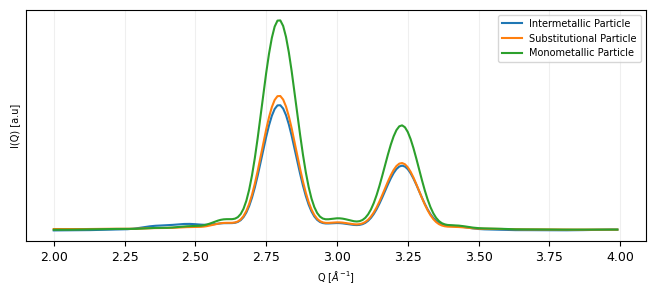

In [222]:
# Calculate Pair Distribution Functions (PDFs) for both models
calc = DebyeCalculator(qmin=2.0, qmax=4.0, qstep=0.01)
iq_output_inter = calc.iq(periodic_plane_model)
iq_output_sub = calc.iq(sub_model)
iq_output_mono = calc.iq(generic_model)

# Plotting the PDFs to compare
fig, ax = plt.subplots(figsize=(8, 3))

# Plot G(r) for the periodic plane model
x_inter, y_inter = iq_output_inter
ax.plot(x_inter, y_inter, label='Intermetallic Particle')

# Plot G(r) for the generic spherical particle model
x_sub, y_sub = iq_output_sub
ax.plot(x_sub, y_sub, label='Substitutional Particle')

# Plot G(r) for the generic spherical particle model
x_mono, y_mono = iq_output_mono
ax.plot(x_mono, y_mono, label='Monometallic Particle')

# Set plot labels and grid
ax.set(xlabel='Q [$Å^{-1}$]', ylabel='I(Q) [a.u]', yticks=[])
ax.grid(alpha=0.2)

# Add a legend to differentiate the curves
ax.legend(loc='upper right')

# Show the plot
plt.show()

---
# Useful For Developers

## Profiling Performance with DebyeCalculator

The `DebyeCalculator` class comes with a built-in profiler that allows you to measure the time taken to execute specific parts of the code. This can be helpful in identifying performance bottlenecks and optimizing your calculations.

The profiler in `DebyeCalculator` is an instance of the `Profiling` class, which tracks the time taken by various methods in the class and provides summary statistics.

### Profiler Demonstration

The next cell demonstrates the use of the profiler by generating scattering for nanoparticles from a `.cif` file. 

In [234]:
# Load the structure file
structure_path = 'data/AntiFluorite_Co2O.cif'

# Profiling for single particle with radius r = 10.0 Å
debye_calc = DebyeCalculator(device='cuda', profile=True, qmin=1, qmax=25, batch_size=10000)
for _ in trange(50):
    _ = debye_calc.gr(structure_path, radii = 10.0)

print(debye_calc.profiler.summary(prefix='Timing per scattering generation:'))

  0%|          | 0/50 [00:00<?, ?it/s]

Timing per scattering generation:
   -> Setup structures and form factors: 204.396ms +- 69.771ms (88.26%) 
   -> G(r): 25.706ms +- 19.509ms (11.10%) 
   -> Batching and Distances: 1.475ms +- 0.431ms (0.64%) 
Total: 231.576ms


The next cell demonstrates the use of the profiler by generating scattering for nanoparticles from a `.xyz` file. 

In [230]:
# Load the structure file
structure_path = 'data/AntiFluorite_Co2O_r10.xyz'

# Profiling for single particle with radius r = 10.0 Å
debye_calc = DebyeCalculator(device='cuda', profile=True, qmin=1, qmax=25, batch_size=10000)
for _ in trange(50):
    r, gr = debye_calc.gr(structure_path)

print(debye_calc.profiler.summary(prefix='Timing per scattering generationn:'))

  0%|          | 0/50 [00:00<?, ?it/s]

Timing per scattering generationn:
   -> G(r): 17.426ms +- 22.939ms (82.51%) 
   -> Setup structures and form factors: 2.741ms +- 1.047ms (12.98%) 
   -> Batching and Distances: 0.953ms +- 0.451ms (4.51%) 
Total: 21.120ms
